# Análisis Exploratorio inicial

Exploración de las primeras tres preguntas del proyecto de pronóstico de demanda usando únicamente `pandas` y `matplotlib`.


In [1]:

import pandas as pd 
import matplotlib.pyplot as plt

CSV = "ventas_hiperrealistas.csv"

meses = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]

#recorre la lista meses asociando un indice (Ene = 1), en donde label es el mes e idx el numero asociado
NumeroMes = {idx + 1: label for idx, label in enumerate(meses)} 
#trabajaremos con series temporales históricas para extraer tendencias y estacionalidad antes de modelar.


In [2]:

df = pd.read_csv(CSV, parse_dates=["Date"])


columnas = df.columns.tolist() #lista con los encabezados
rango = (df["Date"].min().date(), df["Date"].max().date())
print(f"Primer y último registro: {rango[0]} a {rango[1]}")
#Primeras 5 filas
print("primeras 5 filas")
df.head()


Primer y último registro: 2012-01-01 a 2020-12-31
primeras 5 filas


,TransactionID,Date,ProductID,ProductName,ProductCategory,Quantity,UnitPrice,TotalPrice
0,1,2012-01-01,402,Leche Entera 1L,Lácteos,2,950,1900
1,2,2012-01-01,103,Pan de Molde Blanco,Panadería,1,1800,1800
2,3,2012-01-01,101,Refresco Cola 2L,Bebidas,2,1500,3000
3,4,2012-01-01,402,Leche Entera 1L,Lácteos,1,950,950
4,5,2012-01-01,401,Yogurt Frutilla 125g,Lácteos,3,400,1200


## Preguntas


## 1. Análisis Exploratorio y Visualización (15 Puntos)


1. Visión Agregada (5 Puntos): Genere un gráfico de series de tiempo que muestre la evolución de la Cantidad total vendida (sumando todos los productos) a lo largo del tiempo. Comente la tendencia general y cualquier patrón cíclico o estacional que observe a nivel macro.

En esta sección, quisimos aplicar además el método de medias moíviles para poder visualizar de una froma alisada el comportamiento de los datos y así detectar de mejor medida patrones cíclicos y/o estacionales

Resumen de la serie diaria (unidades):
  Inicio operaciones: 2012-01-01
  Final de operaciones: 2020-12-31
  Promedio diario (unidades): 479.0
  Máximo diario (unidades): 2085
  Mínimo diario (unidades): 134


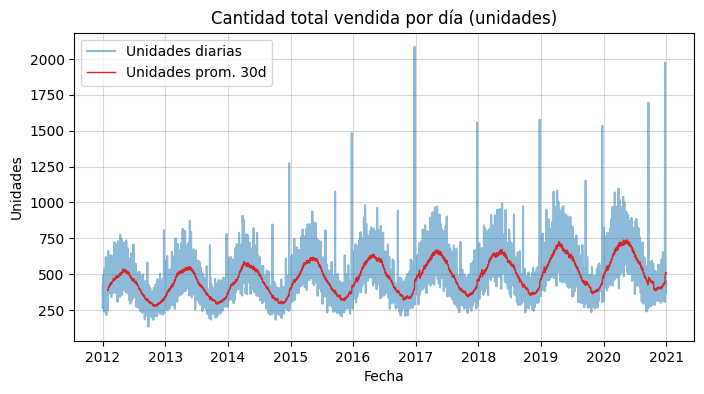

In [3]:

# Series de tiempo: agregamos transacciones a nivel diario (unidades y ventas).

#ordenasmos las ventas diarias, agrupando por fecha y suma de las cantidades vendidas en esa fecha
ventas_diarias = (
    df.groupby('Date')
      .agg(TotalUnidadesDia=('Quantity', 'sum'))
      .reset_index()
      .sort_values('Date')
)

# Medias móviles de 30 días en unidades y ventas
#PU30: Promedio unidades a 30 dias
#PV30: Promedio Ventas a 30 dias
ventas_diarias['PU30'] = ventas_diarias['TotalUnidadesDia'].rolling(window=30, min_periods=30).mean().shift(1)


#Resumen a grandes rasgos del CSV

resumen_unidades = {
    'Inicio operaciones': ventas_diarias['Date'].min().date(),
    'Final de operaciones': ventas_diarias['Date'].max().date(),
    'Promedio diario (unidades)': round(ventas_diarias['TotalUnidadesDia'].mean(), 0),
    'Máximo diario (unidades)': int(ventas_diarias['TotalUnidadesDia'].max()),
    'Mínimo diario (unidades)': int(ventas_diarias['TotalUnidadesDia'].min()),
}

print('Resumen de la serie diaria (unidades):')
for i, valor in resumen_unidades.items():
    print(f'  {i}: {valor}')

#Grafica Serie de tiempo con método medias moviles a 30 dias
#Unidades vendidas
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(ventas_diarias['Date'], ventas_diarias['TotalUnidadesDia'], label='Unidades diarias', alpha=0.5, color='tab:blue')
ax.plot(ventas_diarias['Date'], ventas_diarias['PU30'], label='Unidades prom. 30d', linewidth=1, color='tab:red')
ax.set_title('Cantidad total vendida por día (unidades)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades')
ax.legend()
ax.grid(alpha=0.5)
plt.show()

/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_21563/2506886598.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key="Date", freq="M"))


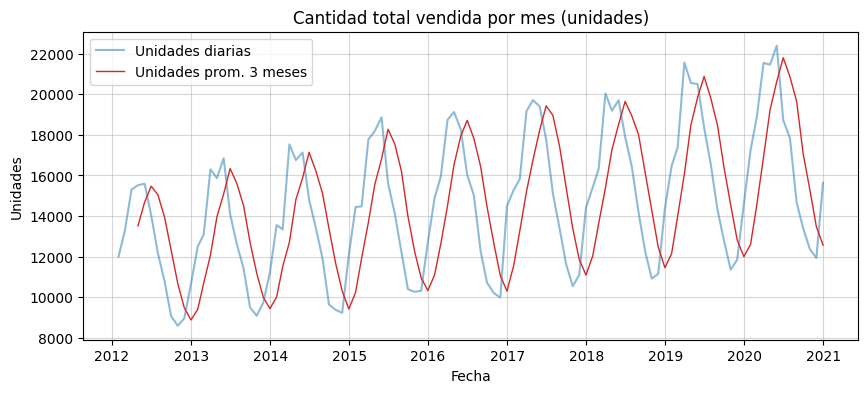

In [4]:
#Gráfico del mes a mes
ventas_mensuales = (
    df.groupby(pd.Grouper(key="Date", freq="M"))
      .agg(TotalUnidadesDia=('Quantity', 'sum'),
           TotalVentasDia=('TotalPrice', 'sum'))
      .reset_index()
      .sort_values('Date')
)
#media movil a 3 meses
ventas_mensuales['PU3'] = ventas_mensuales['TotalUnidadesDia'].rolling(window=3, min_periods=3).mean().shift(1)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ventas_mensuales['Date'], ventas_mensuales['TotalUnidadesDia'], label='Unidades diarias', alpha=0.5, color='tab:blue')
ax.plot(ventas_mensuales['Date'], ventas_mensuales['PU3'], label='Unidades prom. 3 meses', linewidth=1, color='tab:red')
ax.set_title('Cantidad total vendida por mes (unidades)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades')
ax.legend()
ax.grid(alpha=0.5)
plt.show()

Como podemos observar en los graficos, existe precencia de estacionalidad, en donde a nivel anual presentamos el mismo comportamiento en que las ventas suben significativamente hasta una fecha en particular y luego bajan con el mismo o muy similar grado.

2.  Dinámica de Productos (5 Puntos): Cree un único gráfico que muestre las series de tiempo de la Cantidad vendida para la “Leche Entera 1L” y el “Helado Chocolate Suizo 1L”. Compare y contraste visualmente los patrones de demanda de ambos. ¿Son sus tendencias y volatilidades similares?

/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_21563/4031711139.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(key='Date', freq='M'), 'ProductName'])['Quantity']


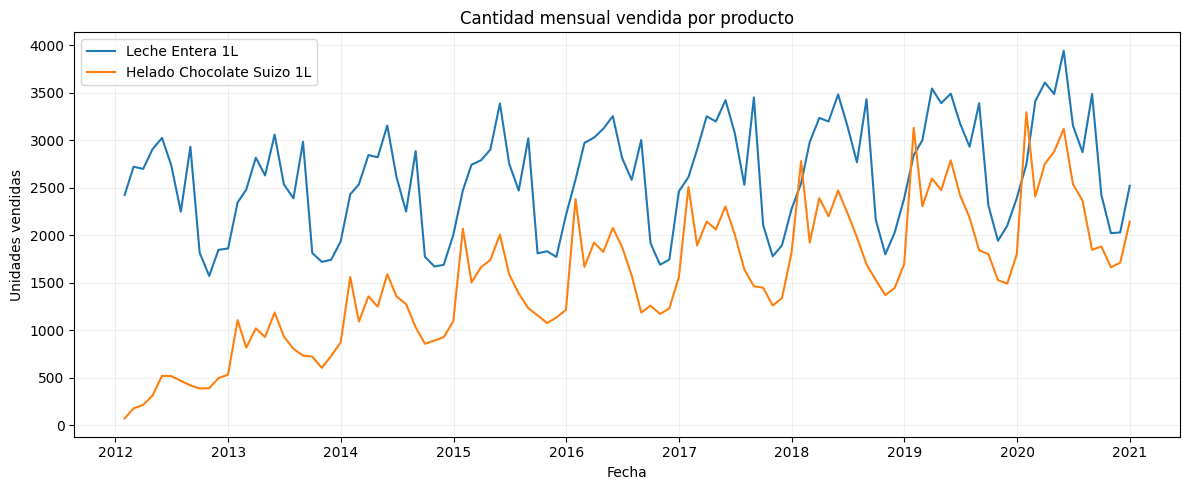

In [5]:
productos= ["Leche Entera 1L", "Helado Chocolate Suizo 1L"]
serie_productos = (
    df[df['ProductName'].isin(productos)]
    .groupby([pd.Grouper(key='Date', freq='M'), 'ProductName'])['Quantity']
    .sum()
    .reset_index()
    .sort_values('Date')
)

helado = serie_productos[serie_productos['ProductName'] == 'Helado Chocolate Suizo 1L']
leche = serie_productos[serie_productos['ProductName'] == 'Leche Entera 1L']

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(leche['Date'], leche['Quantity'], label='Leche Entera 1L')
ax.plot(helado['Date'], helado['Quantity'], label='Helado Chocolate Suizo 1L')

ax.set_title('Cantidad mensual vendida por producto')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades vendidas')
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()


Conclusiones:
Las ventas de leche mantienen volumenes altos y relativamente estables, en donde, si vemos de forma anual, esta suele tener 2 peaks por año, pero en promedio, una gran oscilación anual, popr lo que podemos decir que hay estacionalidad, ahora, esta estacionalidad parece ser aditiva, ya que la amplitud de las oscilaciones no se ve a simple vista un crecimiento significativo año a año. Luego, no se aprecian efectos de tendencia, esta es casi despreciable (constante).

En cuanto a las ventas de helado, podemos ver claramente efectos de tendecia, en donde a comienzos de 2012 posee una demanda baja y a medida que pasan los años, esta demanda va aumentando en promedio de manera aditiva. En cuanto a la estacionalidad, podiramos decir ue lleva una de forma multiplicatica, ya que año a año, posee oscilaciones con una amplitud mayor con el paso del tiempo. Estas oscilaciones parecen tener una correlacion negativa con respecto a las de la leche, pues, cuando la leche alcanza un peak, el helado alcanza un valle.

En cuanto a volatilidad, aparentemente el helado es más volatil, debido a su incremento en los ultimos años y que los peaks y valles de este, se forman de manera más abrupa a comparación de la Leche


3. Análisis de Estacionalidad (5 Puntos): Mediante gráficos de cajas (boxplots), ana- lice la distribución mensual de las ventas para la leche y el helado. ¿Qué meses presentan mayor y menor demanda para cada uno? ¿Confirman los gráficos la hipótesis de que el helado es un producto estacional y la leche es estable?

Leche Entera 1L: mayor mediana en Mayo (3387 unidades), menor en Octubre (1778 unidades)
Helado Chocolate Suizo 1L: mayor mediana en Enero (2380 unidades), menor en Octubre (1171 unidades)


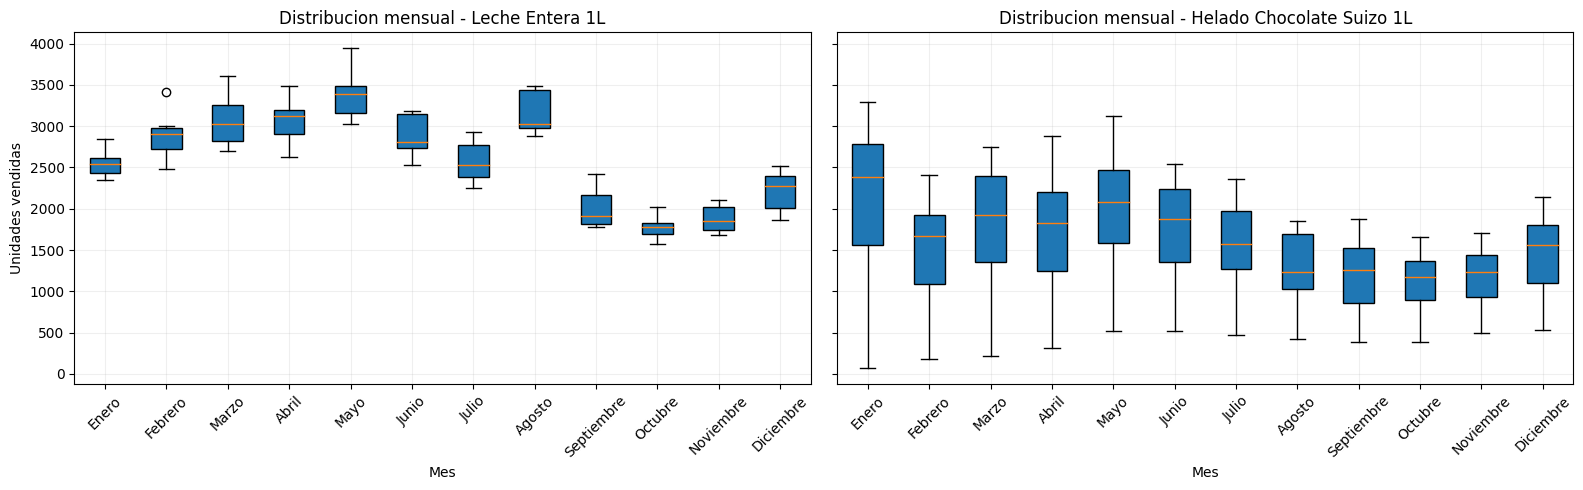

In [6]:

ventas_mensuales_productos= (
    df[df['ProductName'].isin(productos)]
    .groupby([pd.Grouper(key='Date', freq='MS'), 'ProductName'])['Quantity']
    .sum()
    .reset_index()
)

ventas_mensuales_productos['NroMes'] = ventas_mensuales_productos['Date'].dt.month
meses= ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]
ventas_mensuales_productos['MesNombre'] = ''
for i, mes in enumerate(meses, start=1):
    filas_mes = ventas_mensuales_productos['NroMes'] == i
    if filas_mes.any():
        ventas_mensuales_productos.loc[filas_mes, 'MesNombre'] = mes

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
for ax, producto in zip(axes, productos):
    datos_producto = ventas_mensuales_productos[ventas_mensuales_productos['ProductName'] == producto]
    datos_por_mes = [
        datos_producto.loc[datos_producto['MesNombre'] == mes, 'Quantity'].values
        for mes in meses
    ]
    ax.boxplot(datos_por_mes, labels=meses, patch_artist=True)
    ax.set_title(f'Distribucion mensual - {producto}')
    ax.set_xlabel('Mes')
    if ax is axes[0]:
        ax.set_ylabel('Unidades vendidas')
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.2)

plt.tight_layout()

resumen_medianas = (
    ventas_mensuales_productos
    .groupby(['ProductName', 'MesNombre'])['Quantity']
    .median()
    .unstack()
    .reindex(columns=meses)
)
for producto in productos:
    serie = resumen_medianas.loc[producto]
    mes_max = serie.idxmax()
    mes_min = serie.idxmin()
    print(f"{producto}: mayor mediana en {mes_max} ({serie.max():.0f} unidades), menor en {mes_min} ({serie.min():.0f} unidades)")



Conclusiones:
Como podemos ver, en el boxplot de la leche, se observa una disperción poco variable,  las cajas más comprimidas significa que posee ventas más estables, las medianas dicen además que sus ventas suben hasta mediado de año y luego vuelven a bajar.

En cuanto al helado Las cajas son más altas y los bigotes más largos Por lo que existe una gran variabilidad de sus ventas, además los "bigotes" largos que posee implica ventas irregulares y sensibles a factores externos, como es de esperar de un producto como el helado.

Los graficos respaldan que el helado es altamente estacional mientras la leche presenta demanda mas estable y predecible.

## 2. Preparación de Datos


1. Agregación Temporal (3 Puntos): Agregue los datos a una frecuencia temporal regular (diaria, semanal o mensual). Justifique la elección de la frecuencia, considerando el balance entre granularidad y interpretabilidad para productos de retail.


In [7]:
#Dado que en el siguiente item, en donde armamos el modelo, 
# trabajaremos solo con el producto Leche Entera 1L, extraeremos solo la info de ese producto
ventas_leche_semanal = (
    df[df['ProductName'] == "Leche Entera 1L"]
    .set_index('Date')[['Quantity', 'TotalPrice']]
    .resample("W") #frecuencia semanal para entrenar al modelo
    .sum()
    
    .reset_index()
)

print("Ventas de Leche entera primeras 5 semanas:")
print(ventas_leche_semanal.head())

Ventas de Leche entera primeras 5 semanas:
        Date  Quantity  TotalPrice
0 2012-01-01       102       96900
1 2012-01-08       567      538650
2 2012-01-15       526      499700
3 2012-01-22       603      572850
4 2012-01-29       501      475950


Hasta ahora habiamos trabajado de manera mensual para la visualización exploratia de datos de datos, esto ayudó a visualizar con poco ruido la información y hacer analisis sencillos. De todas formas, para preparar los datos decidimos trabajar de forma semanal para conservar el patrón estacional eliminando el ruido que ocasiona verlo de forma diaria, pero tambien para tener suficiente información mensual para trabjar, ya que como en el caso del helado, este poseía ventas muy fuertes durante verano, por lo cual enconrtramos importante mantener de forma más detallada las ventas dentro de cada mes para poder entrenar posteriormente el modelo.

Por otro lado, si utilizamos datos mensuales, tendriamos muy pocos datos parra entrenar el modelo, por lo que creemos qeu el equilibrio está en utilizar un dataset con datos semanales.


2. División de Muestras (2 Puntos): Segmente su serie de tiempo en un conjunto de entrenamiento (primer 80 % de los datos) y uno de prueba (20 % final). Explique por qué esta división es fundamental para una evaluación objetiva del rendimiento del modelo.

In [8]:
cant_registros = len(ventas_leche_semanal)
cant_train = int(cant_registros * 0.8)
ventas_train = ventas_leche_semanal.iloc[:cant_train].copy()
ventas_test = ventas_leche_semanal.iloc[cant_train:].copy()

print(f"En nuestro dataset, tenemos {cant_registros} registros")
print(f"Por lo que usaremos el 80% de ellos para entrenar el modelo, es decir {cant_train} datos")
print(f"El resto será de prueba, es decir {cant_registros - cant_train} datos (último 20%)")

En nuestro dataset, tenemos 471 registros
Por lo que usaremos el 80% de ellos para entrenar el modelo, es decir 376 datos
El resto será de prueba, es decir 95 datos (último 20%)


Utilizar el 80% de los datos para entrenar el modelo permitirá que este tenga una gran cantidad de información para entender el comportamiento de las ventas. Luego, es necesario dejar un porcentaje restante para poder probar el modelo a ver si este logra predecir los datos reales y poder obtener métricas de accuracy para entender qué tanto acierta el modelo.


## 3. Modelamiento y Pronóstico (25 Puntos)

1. Justificación del Modelo (5 Puntos): Describa el modelo de pronóstico que ha elegido. Basándose en los hallazgos del análisis exploratorio (tendencia, estacionalidad), explique por qué este modelo es adecuado para el producto seleccionado. Explique cómo determinó los parámetros clave del modelo.

La leche: El modelo Holt-Winters (alisado exponencial triple aditivo) se justifica porque la serie presenta un patrón estacional claramente repetitivo. Este método permite modelar la estacionalidad y la variabilidad, a diferencia de los dempas modelos vistos que no tienen una componente de estacionalidad. Además, como vimos, las ventas de leche poseen una clara estacionalidad que podrian modelarse de mehor manera con el alisado exponensial triple que con otro método visto

2. Implementación y Entrenamiento (8 Puntos): Implemente el modelo elegido en Python, R o Excel. Entrene el modelo utilizando exclusivamente el conjunto de datos de entrenamiento.

/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_21563/719052033.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M") #frecuencia semanal para entrenar al modelo
/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_21563/719052033.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_train_mes = ventas_train_mes.set_index("Date")["Quantity"].asfreq("M", fill_value=0)
/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_21563/719052033.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y_test_mes  = ventas_test_mes.set_index("Date")["Quantity"].asfreq("M", fill_value=0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Ventas de Leche entera primeros 5 meses:
        Date  Quantity  TotalPrice
0 2012-01-31        72      252000
1 2012-02-29       177      619500
2 2012-03-31       214      749000
3 2012-04-30       310     1085000
4 2012-05-31       519     1816500
En nuestro dataset, tenemos 108 registros
Por lo que usaremos el 80% de ellos para entrenar el modelo, es decir 86 datos
El resto será de prueba, es decir 22 datos (último 20%)
Parámetros ajustados: {'smoothing_level': 0.4646430120655663, 'smoothing_trend': 0.12227454625717545, 'smoothing_seasonal': 0.025493337539989225, 'damping_trend': nan, 'initial_level': 413.0275844749812, 'initial_trend': 1.1059554544965917, 'initial_seasons': array([1.61417468, 1.1636306 , 1.32188737, 1.22799415, 1.38031742,
       1.19408724, 1.02543819, 0.86322876, 0.8179749 , 0.73841984,
       0.77268857, 0.93927367]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
MAE  : 91.17
RMSE : 110.81
MAPE : 4.34%


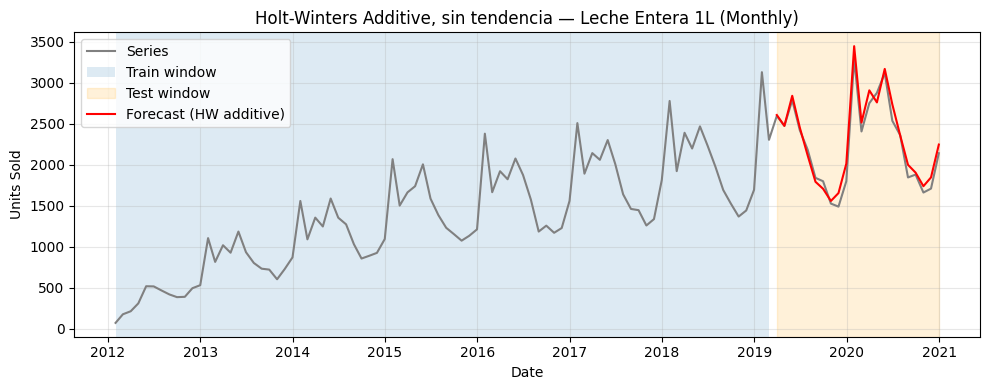

In [ ]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
aw
#Dado que en el siguiente item, en donde armamos el modelo, 
# trabajaremos solo con el producto Leche Entera 1L, extraeremos solo la info de ese producto
ventas_leche_mensual = (
    df[df['ProductName'] == "Helado Chocolate Suizo 1L"]
    .set_index('Date')[['Quantity', 'TotalPrice']]
    .resample("M") #frecuencia semanal para entrenar al modelo
    .sum()
    
    .reset_index()
)

print("Ventas de Leche entera primeros 5 meses:")
print(ventas_leche_mensual.head())
cant_registros_mes = len(ventas_leche_mensual)
cant_train_mes = int(cant_registros_mes * 0.8)
ventas_train_mes = ventas_leche_mensual.iloc[:cant_train_mes].copy()
ventas_test_mes = ventas_leche_mensual.iloc[cant_train_mes:].copy()

print(f"En nuestro dataset, tenemos {cant_registros_mes} registros")
print(f"Por lo que usaremos el 80% de ellos para entrenar el modelo, es decir {cant_train_mes} datos")
print(f"El resto será de prueba, es decir {cant_registros_mes - cant_train_mes} datos (último 20%)")
#We first create two new data frames that can be used by our Holt-Winters model. These dataframe are composed of only the date (by month) and the quantity attributes 

y_train_mes = ventas_train_mes.set_index("Date")["Quantity"].asfreq("M", fill_value=0)
y_test_mes  = ventas_test_mes.set_index("Date")["Quantity"].asfreq("M", fill_value=0)

Model2 = ExponentialSmoothing(
    y_train_mes,
    trend="mul",             # set to None if no trend
    seasonal="mul",         # use "mul" if seasonality scales with level
    seasonal_periods=12
).fit(optimized=True, use_brute=True)  # brute grid first helps avoid local minima

print("Parámetros ajustados:", Model2.params)

# We generate forecast for the test period 
y_pred_2 = Model2.forecast(len(y_test_mes))
y_pred_2.index = y_test_mes.index

# We now compute errors and make a table

mae_2  = mean_absolute_error(y_test_mes, y_pred_2)
rmse_2 = np.sqrt(mean_squared_error(y_test_mes, y_pred_2))

# Avoid dividing by zero when computing MAPE
mask = y_test_mes != 0
mape_2 = np.nan
if mask.any():
    mape_2 = (np.abs((y_test_mes[mask] - y_pred_2[mask]) / y_test_mes[mask])).mean() * 100

print(f"MAE  : {mae_2:,.2f}")
print(f"RMSE : {rmse_2:,.2f}")
print(f"MAPE : {mape_2:,.2f}%")


plt.figure(figsize=(10,4))
y_all = pd.concat([y_train_mes, y_test_mes])
plt.plot(y_all.index, y_all, color='gray', label='Series')
plt.axvspan(y_train_mes.index[0], y_train_mes.index[-1], alpha=0.15, label='Train window')
plt.axvspan(y_test_mes.index[0],  y_test_mes.index[-1],  alpha=0.15, color='orange', label='Test window')
plt.plot(y_pred_2.index,  y_pred_2,  label='Forecast (HW additive)', color='red')

plt.title('Holt-Winters Additive, sin tendencia — Leche Entera 1L (Monthly)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

